# Experiment 5. Multi (LCM)

The modified Multi-column network ([Wang et al, 2018](https://github.com/shepnerd/inpainting_gmcnn)) learns mapping between high-frequency data (> 4 Hz) to the pair of low-frequency data (< 5 Hz) and local subsurface model. At the same time, the optimization fits the trace-wase Pearson correlation coefficient as an extra loss term. "LCM" in the title indicates that the target data are low-frequencies (L) and the local subsurface model (M). The application also uses the trace-wise correlation loss term (C).

The script trains 10 identical models initialized from different random seeds.

------
This notebook reproduces the workflow for an experiment from 
**"Multi-task learning for low-frequency extrapolation and elastic model building from seismic data"**

by [Ovcharenko Oleg](https://ovcharenkoo.com/), [Vladimir Kazei](https://vkazei.com/), [Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Daniel Peter](https://github.com/danielpeter), KAUST, Saudi Arabia, 2021

In [1]:
# Most imports are in the shared_data_loading.ipynb
import os

# This is to prevent the error "this loop already running when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Constrain visibility of GPUs by selected one. This is to enable training of multiple networks each on its own device
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
# Where to save trained model
root_pretrained = os.path.join('./pretrained_files/trained_nets/ex5_multi_lcm/')
root_out = os.path.join('./pretrained_files/trained_nets/ex5_multi_lcm/')

## Load data

1.8.1+cu102
3.8.3 (default, Oct 11 2020, 17:10:44) 
[GCC 7.5.0]
/home/ovcharoo/work/env_torch
{'high': {'flo': 4, 'btype': 'high', 'order': 8}, 'low': {'fhi': 5, 'btype': 'low', 'order': 8}, 'ulow': {'fhi': 2.5, 'btype': 'low', 'order': 8}}


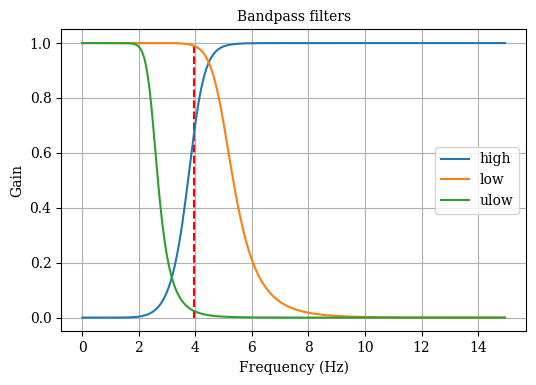

Load cubes from ./pretrained_files/data/syn_1024_el/...
(2765, 324, 376) (2765, 324, 376) (2765, 324, 376) (2765, 324, 376)
(154, 324, 376) (154, 324, 376) (154, 324, 376) (154, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
Processed data loaders: 2765 154
Load ./pretrained_files/data/noise_donors/cube_dst_te_h.npy
(80, 324, 376)
(80, 324, 446)
8


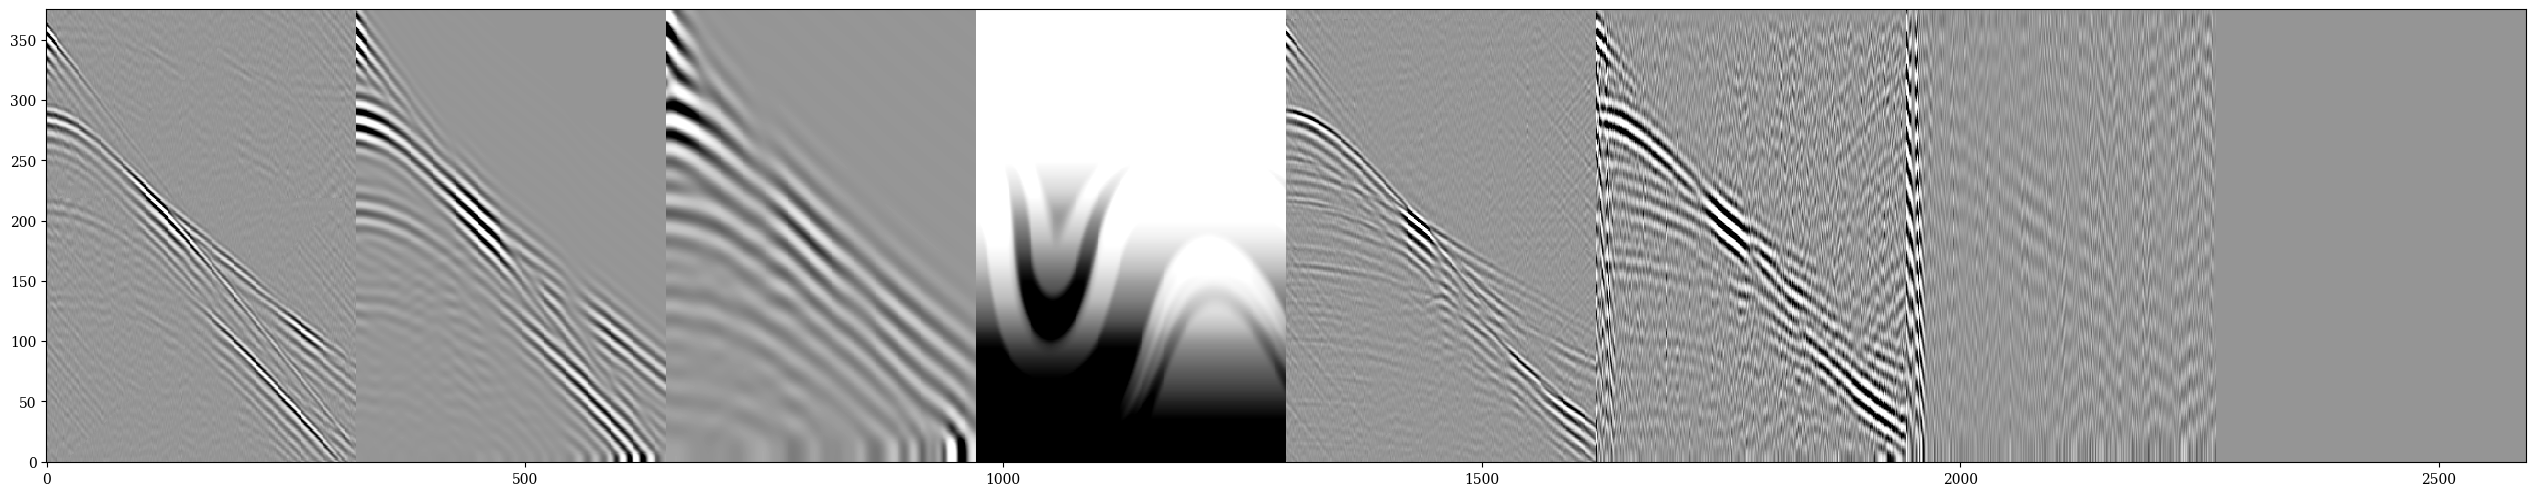

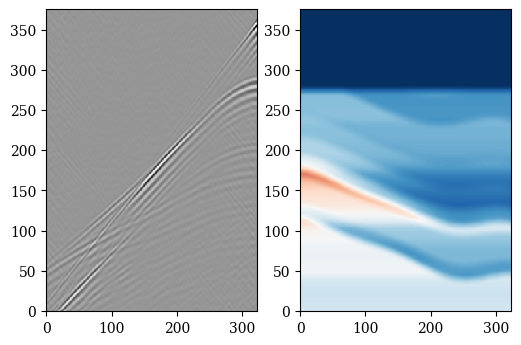

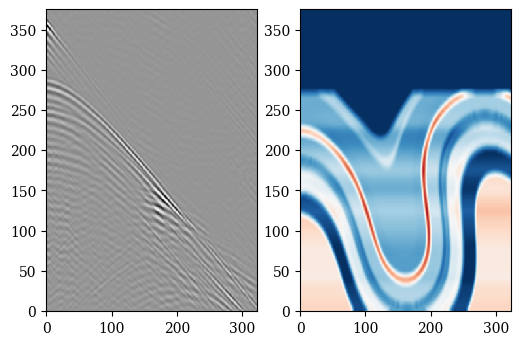

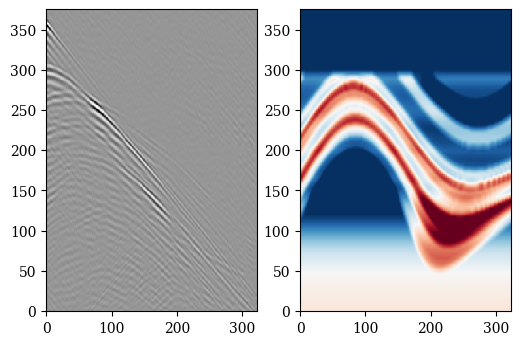

In [4]:
%run shared_data_loading.ipynb

# Multi-head architecture

In [5]:
# Import architectures
from utils.archs import HeadOld, Head, Encoder

## Head model
Keeps the spatial size of the encoder bottleneck but translates it into single channel. The intention is to enforse sparsity in the presicted velocity model

In [6]:
summary(HeadOld(layers=[(56, 16), (16, 1)], kernel_sizes=[3, 3], strides=[1, 1]).to(0), (56, 324, 376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1         [-1, 56, 326, 378]               0
            Conv2d-2         [-1, 16, 324, 376]           8,080
   ReflectionPad2d-3         [-1, 16, 326, 378]               0
            Conv2d-4          [-1, 1, 324, 376]             145
           HeadOld-5          [-1, 1, 324, 376]               0
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 26.02
Forward/backward pass size (MB): 84.42
Params size (MB): 0.03
Estimated Total Size (MB): 110.48
----------------------------------------------------------------



(tensor(8225), tensor(8225))

## Head data
Takes the encoder bottleneck and upscales it to the dimensions of the input data.

In [7]:
summary(Head(layers=[(96, 32), (32, 16)],
             layers_out=(16, 1),
             kernel_sizes=[4, 4], 
             strides=[2, 2], 
             pads=[1, 1]).to(0), (96, 81, 94))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1         [-1, 32, 162, 188]          49,184
         LeakyReLU-2         [-1, 32, 162, 188]               0
   ConvTranspose2d-3         [-1, 16, 324, 376]           8,208
         LeakyReLU-4         [-1, 16, 324, 376]               0
            Conv2d-5         [-1, 16, 324, 376]           2,320
            Conv2d-6          [-1, 1, 324, 376]              17
              Head-7          [-1, 1, 324, 376]               0
Total params: 59,729
Trainable params: 59,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.79
Forward/backward pass size (MB): 61.34
Params size (MB): 0.23
Estimated Total Size (MB): 64.36
----------------------------------------------------------------



(tensor(59729), tensor(59729))

## Multi-column encoder
See _Image Inpainting via Generative Multi-column Convolutional Neural Networks_ by Yi Wang, Xin Tao, Xiaojuan Qi, Xiaoyong Shen, Jiaya Jia for details.

In [8]:
summary(Encoder(1).to(0), (1, 324, 376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 1, 330, 382]               0
            Conv2d-2          [-1, 8, 324, 376]             400
   ReflectionPad2d-3          [-1, 8, 330, 382]               0
            Conv2d-4         [-1, 16, 162, 188]           6,288
   ReflectionPad2d-5         [-1, 16, 168, 194]               0
            Conv2d-6         [-1, 16, 162, 188]          12,560
   ReflectionPad2d-7         [-1, 16, 168, 194]               0
            Conv2d-8           [-1, 32, 81, 94]          25,120
   ReflectionPad2d-9          [-1, 32, 87, 100]               0
           Conv2d-10           [-1, 32, 81, 94]          50,208
  ReflectionPad2d-11          [-1, 32, 87, 100]               0
           Conv2d-12           [-1, 32, 81, 94]          50,208
  ReflectionPad2d-13          [-1, 32, 93, 106]               0
           Conv2d-14           [-1, 32,

(tensor(838992), tensor(838992))

# Define training

In [9]:
# from https://github.com/audeering/audtorch/blob/master/audtorch/metrics/functional.py
def pearsonr(x, y):
    """ Pearson Correlation Coefficient, ranging from -1 to 1."""
    dim = -1
    centered_x = x - x.mean(dim=dim, keepdim=True)
    centered_y = y - y.mean(dim=dim, keepdim=True)

    covariance = (centered_x * centered_y).sum(dim=dim, keepdim=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(dim=dim, keepdim=True)
    y_std = y.std(dim=dim, keepdim=True)

    corr = bessel_corrected_covariance / (x_std * y_std)
    return corr


def loss_corr(x, y):
    """ The trace-wise correlation loss term based on Pearson coefficient: 1 - Pearson, spans the range from 0 to 2. """
    r = pearsonr(x, y)
    b, c, h, w = r.size()
    return (torch.ones_like(r) - r).sum().div(b * c * h)


# https://discuss.pytorch.org/t/implement-total-variation-loss-in-pytorch/55574/2
def loss_tv(x):
    """ Total variation loss"""
    b, c, h, w = x.size()
    tv_h = torch.pow(x[:, :, 1:, :]-x[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(x[:, :, :, 1:]-x[:, :, :, :-1], 2).sum()
    return (tv_h + tv_w) / (b * c * h * w)

In [10]:
# Plot training curves
def plot_metrics(m, title='', secondary_key=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    axis = [ax, ax.twinx()]
    colors = ['r', 'b', 'm', 'c', 'g', 'navy']
    
    for phase, loss_dict in m.items():
        color_phase = '--' if phase == 'val' else ''
        for i, (ln, val) in enumerate(loss_dict.items()):
            if secondary_key is not None:
                if secondary_key in ln:
                    axis[1].semilogy(val, colors[i] + color_phase, label=f'{ln}_{phase}')
                else:
                    axis[0].semilogy(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            else:
                axis[0].semilogy(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            
    axis[0].legend(loc='upper right')
    if secondary_key is not None:
        axis[1].legend(loc='lower right')
    axis[0].set_title(title)

In [11]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

def plot_metrics3(m, title='', secondary_key=None, ax=None):
    
    data1_train = m['train']['data']
    data1_val = m['val']['data']
    
    data2_train = m['train']['model']
    data2_val = m['val']['model']
    
    data3_train = m['train']['corr']
    data3_val = m['val']['corr']
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    ax.plot(data1_train, 'r', label="data_train")
    ax.plot(data2_train, 'b', label="model_train")
    ax.plot(data3_train, 'm', label="corr_train")
    
    ax.plot(data1_val, 'r--', label="data_val")
    ax.plot(data2_val, 'b--', label="model_val")
    ax.plot(data3_val, 'm--', label="corr_val")
    
    ax.legend()

### Wrapper 

In [12]:
def log_to_weight(log_var):
    # Valid for regression task only
    return np.exp(-log_var) / 2
    
class LFNet(backbone.BaseModel):
    def __init__(self, opt, device, imodel=None):
        super().__init__()
        
        # Init model with fixed random seed
        this_seed = 1 + imodel * 100
        torch.manual_seed(this_seed)
        np.random.seed(this_seed)
        
        # Check gpu availability
        self.gpu_ids = [i for i in range(torch.cuda.device_count())]
        self.device = opt['device'] if opt['device'] else min(self.gpu_ids)
        self.imodel = imodel
        
        # Init architectures
        self.net_encoder = Encoder(1)          
        self.net_data = Head(layers=[(96, 32), (32, 16)],
             layers_out=(16, 1),
             kernel_sizes=[4, 4], 
             strides=[2, 2], 
             pads=[1, 1])
        self.net_model = HeadOld(layers=[(96, 32), (32, 1)], kernel_sizes=[3, 3], strides=[1, 1])
        
        # Init weights
        backbone.init_weights(self.net_encoder, 'kaiming')
        backbone.init_weights(self.net_data, 'kaiming')
        backbone.init_weights(self.net_model, 'kaiming') 
            
        self.opt = opt
        self.load_dir = opt['load_pretrained']
        self.save_dir = opt['save_dir']
        self.epochs = opt['epochs']
        self.enable_scheduler = opt['scheduler']

        self.model_names = ['_encoder', '_data', '_model']
        self.phases = ['train', 'val']
        self.running_metrics_encoder = {}
        self.running_metrics_lr = {'train': {'lr_data': [], 'lr_model': []}}
        self.running_metrics_data = {'train': {'w1': [], 'w2': [], 'w3': [], 'w_s1s2s3': []}}
        for p in self.phases:
            self.running_metrics_encoder[p] = {'data': [], 'model': [], 'corr': []}
        
        # ==========================
        # Multi-task learning (due to the issue with making sigmas leaf nodes I am overwriting these a few lines later)
        print('Init sigmas')
        self.loss_weights = [torch.ones((1,), requires_grad=False) for _ in range(3)]
        
        # Load if previous specified
        if self.load_dir:
            self.load_networks(self.load_dir, 0)
            self.load_history(self.load_dir)
            self.load_lr_history(self.load_dir)
            self.load_sigmas(self.load_dir)
        else:
            # Set zeros otherwise
            self.loss_weights = [w * 0 for w in self.loss_weights]

        # Convert to leaf nodes
        print('Convert to leaf nodes')
        self.loss_weights = [w.clone().to(self.device).detach().requires_grad_(True) for w in self.loss_weights]
        print([torch.exp(w).item()**0.5 for w in self.loss_weights])
        # ==========================
        
        # MAE loss used for data and model fit
        self.loss_pix = nn.L1Loss()
        
        # Send to device
        self.net_encoder = self.net_encoder.to(self.device)
        self.net_data = self.net_data.to(self.device)
        self.net_model = self.net_model.to(self.device)
        
        # Cast to multiple GPUs
        if len(self.gpu_ids) > 1:
            print(f'DataParallel on {self.gpu_ids}')
            self.net_encoder = torch.nn.DataParallel(self.net_encoder, device_ids=self.gpu_ids)
            self.net_data = torch.nn.DataParallel(self.net_data, device_ids=self.gpu_ids)
            self.net_model = torch.nn.DataParallel(self.net_model, device_ids=self.gpu_ids)
            params_data = list(self.net_encoder.module.parameters()) + list(self.net_data.module.parameters())
            params_model = list(self.net_encoder.module.parameters()) + list(self.net_model.module.parameters())
        else:
            params_data = list(self.net_encoder.parameters()) + list(self.net_data.parameters())
            params_model = list(self.net_encoder.parameters()) + list(self.net_model.parameters())

        # Init separate optimizers for data and model heads
        self.optimizer_data = torch.optim.Adam(params_data + self.loss_weights, 
                                            lr=opt['lr_min'], betas=(0.5, 0.9), weight_decay=1e-5)
        self.optimizer_model = torch.optim.Adam(params_model + self.loss_weights, 
                                            lr=opt['lr_min'], betas=(0.5, 0.9), weight_decay=1e-5)
        
        # Init schedulers
        # https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
        self.scheduler_data = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_data, 
                                                        max_lr=opt['lr_max'],
                                                        cycle_momentum=False,
                                                        epochs=self.epochs,
                                                        steps_per_epoch=opt['len_loader'])
        
        self.scheduler_model = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_model, 
                                                        max_lr=opt['lr_max'],
                                                        cycle_momentum=False,
                                                        epochs=self.epochs,
                                                        steps_per_epoch=opt['len_loader'])

    def load_sigmas(self, load_dir):
        print(f'Load sigmas from {load_dir}')
        try:
            available_weights = self.loss_weights
            self.loss_weights = [available_weights[iw].clone() * np.load(os.path.join(load_dir, f's{iw}.npy')).astype(np.float32) 
                                 for iw in range(len(self.loss_weights))]
        except Exception as e:
            print(f'Failed to load sigmas from {load_dir}! {e}')
    
    def save_sigmas(self, save_dir):
        print(f'Save sigmas to {save_dir}')
        for iw, w in enumerate(self.loss_weights):
            np.save(os.path.join(save_dir, f's{iw}.npy'), sd.dcn(w))

    def train_batch(self, data, phase, scaler):
        hs = data[0].to(self.device) # syn high-freq input data, > 4 Hz
        ls = data[1].to(self.device) # syn low-freq target data, < 5 Hz
        ms = data[4].to(self.device)[..., ::4, ::4] # syn local subsurface model

        with torch.set_grad_enabled(phase != 'val'):
            # Enable automatic mixed precision training
            with autocast():
                # Predict
                hs_encoded = self.net_encoder(hs)
                lsp = self.net_data(hs_encoded) # low and ulow data
                msp = self.net_model(hs_encoded) # model

                # Losses
                loss_g = 0

                # Data fit
                loss_data = self.loss_pix(lsp, ls.detach()).sum()
                w_loss_data = torch.exp(-self.loss_weights[0]) / 2
                loss_g += w_loss_data * loss_data + 0.5 * self.loss_weights[0]

                # Model fit
                loss_model = self.loss_pix(msp, ms.detach()).sum()
                w_loss_model = torch.exp(-self.loss_weights[1]) / 2
                loss_g += w_loss_model * loss_model + 0.5 * self.loss_weights[1]

                # Correlation fit
                loss_data_fft = loss_corr(lsp, ls.detach()).sum()# / self.opt['len_loader']
                w_loss_corr = torch.exp(-self.loss_weights[2]) / 2
                loss_g += w_loss_corr * loss_data_fft + 0.5 * self.loss_weights[2]

                # TV regulatization on ultra-low frequencies
                loss_tv_msp = self.opt['w_tv'] * loss_tv(msp).sum()
                loss_g += loss_tv_msp

                loss_g = loss_g.sum()


            if phase == "train":
                self.optimizer_data.zero_grad()
                self.optimizer_model.zero_grad()

                scaler.scale(loss_g).backward()
                scaler.step(self.optimizer_data)
                scaler.step(self.optimizer_model)

                if self.enable_scheduler:
                    self.scheduler_data.step()
                    self.scheduler_model.step()

                scaler.update()
        
        return loss_data, loss_model, loss_data_fft, loss_tv_msp
    
    def train(self, dtrain, dval):
        os.makedirs(self.save_dir, exist_ok=True)
        t1 = time.time()
        for iepoch in range(self.epochs):
            clear_output()
            # Print outs
            if iepoch > 0:
                w_loss_data = torch.exp(-self.loss_weights[0]) / 2
                w_loss_model = torch.exp(-self.loss_weights[1]) / 2
                w_loss_corr = torch.exp(-self.loss_weights[2]) / 2
                
                print(f'Model {self.imodel}. Stats for last epoch {iepoch}.')
                print('loss_data = {:.2f} * {:.2f} = {:.2f}'.format(w_loss_data.sum().item(), loss_data, 
                                                                    w_loss_data.sum().item() * loss_data))
                print('loss_model = {:.2f} * {:.2f} = {:.2f}'.format(w_loss_model.sum().item(), loss_model, 
                                                                     w_loss_model.sum().item() * loss_model))
                print('loss_corr = {:.2f} * {:.2f} = {:.2f}'.format(w_loss_corr.sum().item(), loss_data_fft, 
                                                                     w_loss_corr.sum().item() * loss_data_fft))
                print('compensator = {:.2f} * {:.2f} * {:.2f} = {:.2f}'.format(0.5 * self.loss_weights[0].sum().item(),
                                                                              0.5 * self.loss_weights[1].sum().item(),
                                                                              0.5 * self.loss_weights[2].sum().item(),
                                                                              0.5 * self.loss_weights[0].sum().item() * \
                                                                              0.5 * self.loss_weights[1].sum().item() * \
                                                                              0.5 * self.loss_weights[2].sum().item()))
                print('loss_tv_msp = {}'.format(loss_tv_msp))

            # Plot curves from previous epoch
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
            plot_metrics3(self.running_metrics_encoder, title=f'Generator. Epoch {iepoch} / {self.epochs}', 
                         secondary_key='data', ax=ax[0])
            plot_metrics(self.running_metrics_data, title=f'Sigmas. Epoch {iepoch} / {self.epochs}', 
                         secondary_key='s1s2s3', ax=ax[1])
            plot_metrics(self.running_metrics_lr, title=f'Learning Rate. Epoch {iepoch} / {self.epochs}', 
                         secondary_key='data', ax=ax[2])
            plt.pause(1e-4)
            print(f'{iepoch+1}/{self.epochs} ...')
                                                                
            for phase in self.phases:
                print(phase)
                if phase=='train':
                    data_loader = dtrain
                else:
                    data_loader = dval
                
                # FP16 converter for automatic-mixed-precision training
                scaler = torch.cuda.amp.GradScaler()
                
                prog_bar = tqdm.auto.tqdm(data_loader)
                
                # Get loss values and append them to training curves
                losses = [0, 0, 0, 0]
                for i, data in enumerate(prog_bar):
                    these_losses = self.train_batch(data, phase, scaler)
                    losses = [losses[i] + these_losses[i].mean().item() for i in range(4)]
                losses = [l / len(prog_bar) for l in losses]
                
                loss_data, loss_model, loss_data_fft, loss_tv_msp = losses
                self.running_metrics_encoder[phase]['data'].append(loss_data)
                self.running_metrics_encoder[phase]['model'].append(loss_model)
                self.running_metrics_encoder[phase]['corr'].append(loss_data_fft)
            
            # Remember learning rates and sigmas per epoch
            self.running_metrics_lr['train']['lr_data'].append(self.optimizer_data.param_groups[0]["lr"]) 
            self.running_metrics_lr['train']['lr_model'].append(self.optimizer_model.param_groups[0]["lr"]) 
            for iw, w in enumerate(self.loss_weights):
                self.running_metrics_data['train'][f'w{iw+1}'].append(log_to_weight(w.sum().item()))
            self.running_metrics_data['train']['w_s1s2s3'].append(sum([w.sum().item() * 0.5 for w in self.loss_weights])) 

            # Save networks every 5th epoch
            if iepoch == 0 or (iepoch + 1) % 5 == 0:
                print(f'Save state at epoch {iepoch}')
                self.save_networks(0)
                self.save_history(self.save_dir)
                self.save_lr_history(self.save_dir)
                self.save_sigmas(self.save_dir)

    def from_numpy(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, 0)
        return torch.from_numpy(x).type(torch.FloatTensor).to(self.device)

    def predict(self, h):
        if isinstance(h, np.ndarray):
            h = self.from_numpy(h)
        x = self.net_encoder(h)
        lp = self.net_data(x)
        mp = self.net_model(x)

        # Predict ultra-low, low frequencies, subsurface model
        return sd.dcn(lp), sd.dcn(lp), sd.dcn(mp)

## Train an ensemble of networks

In [13]:
opt= {'batch_size': 4,
       'epochs': 81,
        'lr_min': 1e-5,
        'lr_max': 1e-3,
        'load_pretrained': '',
        'save_dir': root_out,
      'device': 0,
      'data_idx': 1,
      'w_tv': 1e-3,
      'scheduler': True}

dataset_train = torch.utils.data.DataLoader(jjloader_tr, 
                                            batch_size=opt['batch_size'], 
                                            shuffle=True, 
                                            num_workers=4, 
                                            drop_last=True, 
                                            pin_memory=True)
dataset_val = torch.utils.data.DataLoader(jjloader_te, 
                                          batch_size=opt['batch_size'], 
                                          shuffle=False, 
                                          num_workers=4, 
                                          drop_last=False, 
                                          pin_memory=True)
# Need the line below for OneCycle scheduler
opt['len_loader'] = len(dataset_train)

In [14]:
# Uncomment below to train from scratch
# for i in range(0,10):
#     opt['save_dir'] = root_out[:-1] + f'_{i}'
# #     opt['load_pretrained'] = root_pretrained[:-1] + f'_{i}'
#     opt['load_pretrained'] = ''
#     net = LFNet(opt, 0, i)
#     net.train(dataset_train, dataset_val)

https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example-pytorch.ipynb

https://pytorch.org/docs/stable/notes/amp_examples.html

https://paperswithcode.com/paper/multi-task-learning-using-uncertainty-to#code

https://towardsdatascience.com/self-paced-multitask-learning-76c26e9532d0

## Load one pre-trained network

In [15]:
opt['load_pretrained'] = root_out[:-1] + f'_{0}'
net = LFNet(opt, 0, i)

initialize network with kaiming
initialize network with kaiming
initialize network with kaiming
Init sigmas
Load weights for _encoder
Loading model from ./pretrained_files/trained_nets/ex5_multi_lcm_0/0_net_encoder.pth
Load weights for _data
Loading model from ./pretrained_files/trained_nets/ex5_multi_lcm_0/0_net_data.pth
Load weights for _model
Loading model from ./pretrained_files/trained_nets/ex5_multi_lcm_0/0_net_model.pth
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_encoder.pkl...
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_data.pkl...
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_model.pkl...
Failed to load history form ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_model.pkl, [Errno 2] No such file or directory: './pretrained_files/trained_nets/ex5_multi_lcm_0/history_model.pkl'
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_lr.pkl...
Load sigmas

https://discuss.pytorch.org/t/how-to-learn-the-weights-between-two-losses/39681/12

/home/ovcharoo/work/env_torch/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


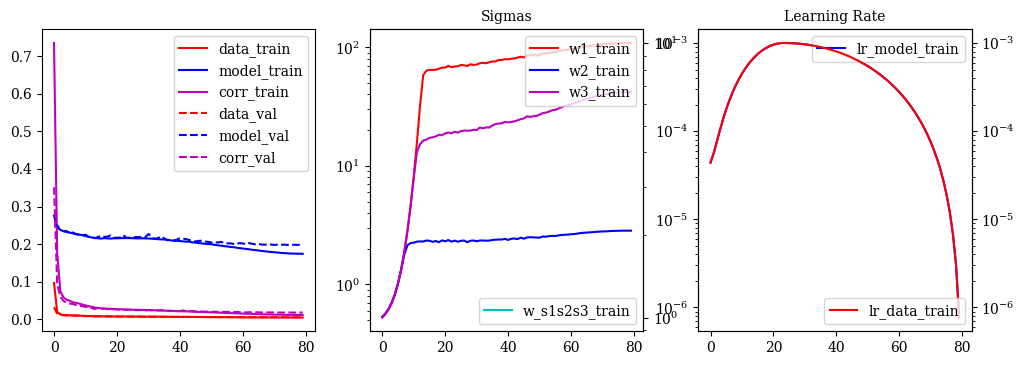

In [16]:
# Plot curves from previous epoch
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plot_metrics3(net.running_metrics_encoder, title=f'Generator', 
             secondary_key='data', ax=ax[0])
plot_metrics(net.running_metrics_data, title=f'Sigmas', 
             secondary_key='s1s2', ax=ax[1])
plot_metrics(net.running_metrics_lr, title=f'Learning Rate', 
             secondary_key='data', ax=ax[2])

Structure of data, d:
```0 - syn input
1 - syn low
2 - syn ulow
3 - velocity model
4 - field input
5 - field low
6 - filed ulow
7 - velocity model (zeros)```

In [17]:
hs_true = d[0].copy()
print(hs_true.shape)
us_pred, ls_pred, ms_pred = net.predict(hs_true)
print(ls_pred.shape)
print(us_pred.shape)
print(ms_pred.shape)

(1, 324, 376)
(1, 1, 324, 376)
(1, 1, 324, 376)
(1, 1, 81, 94)


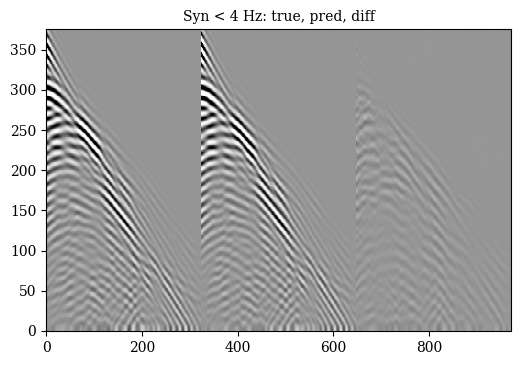

In [18]:
nt_clip=None
vlim_f = {'vmin': -0.25, 'vmax': 0.25}
vlim_2f = {'vmin': -0.125, 'vmax': 0.125}
fhp = 0.5
fedge = par['fedge']
dt_net = dt

ls_true = d[1].copy().astype(np.float32); lst = ls_true[0,...].astype(np.float32); 
ls = ls_pred[0,0,...].astype(np.float32); hst=hs_true[0,...].astype(np.float32)
# lst = ld.bandpass(lst, fs=1/dt_net, flo=fhp, btype='high')
# ls = ld.bandpass(ls, fs=1/dt_net, flo=fhp, btype='high')
vis.plot_shot(np.concatenate([lst, ls, lst - ls]), colorbar=False, **vlim_f,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')
# vis.plot_wiggles([lst[:, :nt_clip], ls[:, :nt_clip]], n=5)

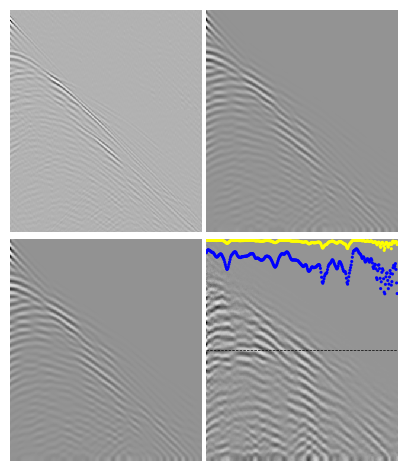

In [19]:
vis.imgrid(hst, lst, [ls], diff_of_diff=False, figsize=(5,6), scatter_size=5)

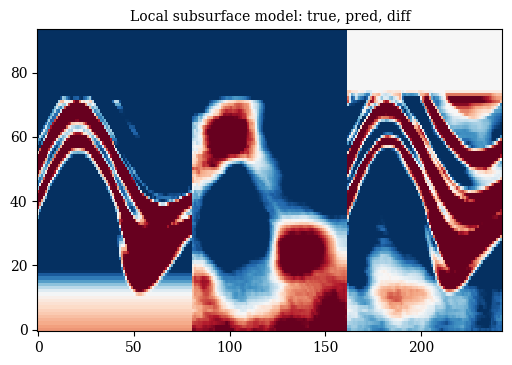

In [21]:
ms_true = d[3].copy().astype(np.float32); mst = ms_true[0,::4,::4].astype(np.float32); 
ms = ms_pred[0,0,...].astype(np.float32)
vis.plot_shot(np.concatenate([mst, ms, mst - ms]), colorbar=False, **vlim_f,
              title=f'Local subsurface model: true, pred, diff', cmap='RdBu_r')